In [107]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import datetime, os
import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
import simplejson as json
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import metrics as skmetrics
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.utils.vis_utils import plot_model
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate, SimpleRNN, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from google.cloud import storage
from google.cloud.storage import Blob
import seaborn as sns

client = storage.Client(project="ds5500")

bucket = client.get_bucket("kkbox-data")

#INPUT_PATH = "D:\\Northeastern\\100 pct undersample split\\"
INPUT_PATH = "gs://kkbox-data/50_pct_undersample/"

In [114]:
# Create F1 score as an evaluation metric
# https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

import sklearn.metrics as skmetrics


# Load Member/Transaction Data

In [81]:
# Load TRAINING data
temp_path = "/tmp/train_transactions_monthly_padded.npy"
blob = Blob("50_pct_undersample/train_transactions_monthly_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_transactions = np.load(temp_path)
X_members = pd.read_csv(INPUT_PATH + "train_members_transformed.csv").sort_values("msno").drop(["msno","is_churn"],axis=1).values
y = pd.read_csv(INPUT_PATH + "train_members_transformed.csv").sort_values("msno").is_churn.values

# Load VALIDATION data
temp_path = "/tmp/val_transactions_monthly_padded.npy"
blob = Blob("50_pct_undersample/val_transactions_monthly_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_transactions = np.load(temp_path)
X_val_members = pd.read_csv(INPUT_PATH + "val_members_transformed.csv").sort_values("msno").drop(["msno","is_churn"],axis=1).values
y_val = pd.read_csv(INPUT_PATH + "val_members_transformed.csv").sort_values("msno").is_churn

# Load TEST data
temp_path = "/tmp/test_transactions_monthly_padded.npy"
blob = Blob("50_pct_undersample/test_transactions_monthly_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_test_transactions = np.load(temp_path)
X_test_members = pd.read_csv(INPUT_PATH + "test_members_transformed.csv").sort_values("msno").drop(["msno","is_churn"],axis=1).values
y_test = pd.read_csv(INPUT_PATH + "test_members_transformed.csv").sort_values("msno").is_churn

## Load Weekly User Logs

In [103]:
# Load training weekly user logs from GCS
temp_path = "/tmp/train_user_logs_weekly_padded.npy"
blob = Blob("50_pct_undersample/train_user_logs_weekly_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_user_logs_weekly = np.load(temp_path)

# Load val weekly user logs from GCS
temp_path = "/tmp/val_user_logs_weekly_padded.npy"
blob = Blob("50_pct_undersample/val_user_logs_weekly_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_user_logs_weekly = np.load(temp_path)

# Load test weekly user logs from GCS
temp_path = "/tmp/test_user_logs_weekly_padded.npy"
blob = Blob("50_pct_undersample/test_user_logs_weekly_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_test_user_logs_weekly = np.load(temp_path)

# Just Weekly User Logs

In [72]:
batch_size = 64
epochs = 50
lstm_units = 16

num_dates = X_user_logs_weekly.shape[1]
num_user_log_cols = X_user_logs_weekly.shape[2]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units, return_sequences=True)(data_in_a)
a = Conv1D(filters=16, kernel_size=5, strides=2)(a)
a = MaxPooling1D()(a)
a = LSTM(lstm_units)(a)
a = Dense(8)(a)
a = Dropout(.2)(a)
a = Dense(8)(a)
out = Dense(1, activation='sigmoid')(a)

model_2a = Model(inputs=data_in_a, outputs=out)
model_2a.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [f1])

#model_2a.summary()
history_1 = model_2a.fit(X_user_logs_weekly, y, 
                         batch_size=batch_size, 
                         validation_data=(X_val_user_logs,y_val), 
                         epochs=epochs,verbose=1,
                         use_multiprocessing=True) # try class_weight={0: 1, 1: 3}

Train on 53483 samples, validate on 21517 samples
Epoch 1/50
53483/53483 [==============================] - 28s 527us/step - loss: 0.5952 - f1: 0.3127 - val_loss: 0.4569 - val_f1: 0.1654
Epoch 2/50
53483/53483 [==============================] - 25s 460us/step - loss: 0.5686 - f1: 0.4381 - val_loss: 0.4207 - val_f1: 0.1761
Epoch 3/50
53483/53483 [==============================] - 24s 456us/step - loss: 0.5613 - f1: 0.4604 - val_loss: 0.3726 - val_f1: 0.1862
Epoch 4/50
53483/53483 [==============================] - 25s 460us/step - loss: 0.5564 - f1: 0.4713 - val_loss: 0.3721 - val_f1: 0.1859
Epoch 5/50
53483/53483 [==============================] - 25s 464us/step - loss: 0.5541 - f1: 0.4838 - val_loss: 0.3641 - val_f1: 0.1846
Epoch 6/50
53483/53483 [==============================] - 26s 480us/step - loss: 0.5534 - f1: 0.4789 - val_loss: 0.3549 - val_f1: 0.1889
Epoch 7/50
53483/53483 [==============================] - 24s 440us/step - loss: 0.5526 - f1: 0.4839 - val_loss: 0.3832 - val_f1

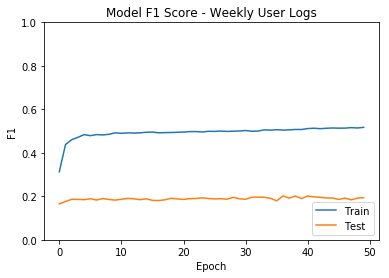

In [73]:
# Plot training & validation accuracy values
plt.plot(history_1.history['f1'])
plt.plot(history_1.history['val_f1'])
plt.title('Model F1 Score - Weekly User Logs')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim([0,1])
plt.show()

In [105]:
from sklearn.metrics import recall_score, precision_score
y_true = y_test.values
y_pred = np.round(model_2a.predict(X_test_user_logs_weekly)).flatten()
print("Model 2A Recall " + str(recall_score(y_true,y_pred)))
print("Model 2A Precision " + str(precision_score(y_true,y_pred)))

Model 2A Recall 0.37844611528822053
Model 2A Precision 0.1641304347826087


# Weekly User Logs, Member Data, Transaction Data

In [120]:
batch_size = 64
epochs = 50
lstm_units = 16
rnn_units = 16

num_members = X_user_logs_weekly.shape[0]
num_dates = X_user_logs_weekly.shape[1]
num_user_log_cols = X_user_logs_weekly.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units, return_sequences=True)(data_in_a)
a = Conv1D(filters=16, kernel_size=5, strides=2)(a)
a = MaxPooling1D()(a)
a = LSTM(lstm_units)(a)
a = Dense(16, activation='relu')(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c = Dense(16, activation='relu')(c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([a_mod.output, b_mod.output, c_mod.output])
out = Dense(32, activation='relu')(combined)
out = Dropout(.02)(out)
out = Dense(16, activation='relu')(out)
out = Dense(1, activation='sigmoid')(out)

model_1 = Model(inputs=[a_mod.input, b_mod.input, c_mod.input], outputs=out)
model_1.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [f1])

#model_1.summary()
history_2 = model_1.fit([X_user_logs_weekly, X_members, X_transactions], y, validation_data=([X_val_user_logs_weekly, X_val_members, X_val_transactions],y_val), batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Train on 53483 samples, validate on 21517 samples
Epoch 1/50
53483/53483 [==============================] - 28s 527us/step - loss: 0.3980 - f1: 0.7463 - val_loss: 0.2425 - val_f1: 0.3304
Epoch 2/50
53483/53483 [==============================] - 26s 492us/step - loss: 0.3717 - f1: 0.7716 - val_loss: 0.2843 - val_f1: 0.3088
Epoch 3/50
53483/53483 [==============================] - 25s 466us/step - loss: 0.3668 - f1: 0.7742 - val_loss: 0.2670 - val_f1: 0.3027
Epoch 4/50
53483/53483 [==============================] - 27s 509us/step - loss: 0.3637 - f1: 0.7763 - val_loss: 0.2497 - val_f1: 0.3258
Epoch 5/50
53483/53483 [==============================] - 25s 461us/step - loss: 0.3612 - f1: 0.7754 - val_loss: 0.2579 - val_f1: 0.3191
Epoch 6/50
53483/53483 [==============================] - 25s 458us/step - loss: 0.3602 - f1: 0.7765 - val_loss: 0.2789 - val_f1: 0.3169
Epoch 7/50
53483/53483 [==============================] - 25s 465us/step - loss: 0.3589 - f1: 0.7771 - val_loss: 0.2550 - val_f1

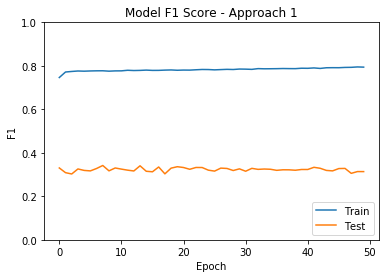

In [121]:
# Plot training & validation accuracy values
plt.plot(history_2.history['f1'])
plt.plot(history_2.history['val_f1'])
plt.title('Model F1 Score - Approach 1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim([0,1])
plt.show()

In [122]:
from sklearn.metrics import recall_score, precision_score
y_true = y_test.values
y_pred = np.round(model_1.predict([X_test_user_logs_weekly, X_test_members, X_test_transactions])).flatten()
print("Model 1 Recall " + str(recall_score(y_true,y_pred)))
print("Model 1 Precision " + str(precision_score(y_true,y_pred)))

Model 1 Recall 0.4323308270676692
Model 1 Precision 0.23232323232323232


# Load Daily User Logs

In [123]:
# Load user logs from GCS
temp_path = "/tmp/train_user_logs_padded.npy"
blob = Blob("50_pct_undersample/train_user_logs_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_user_logs = np.load(temp_path)

# Load val user logs from GCS
temp_path = "/tmp/val_user_logs_padded.npy"
blob = Blob("50_pct_undersample/val_user_logs_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_user_logs = np.load(temp_path)

# Load test user logs from GCS
temp_path = "/tmp/test_user_logs_padded.npy"
blob = Blob("50_pct_undersample/test_user_logs_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_test_user_logs = np.load(temp_path)

# Just Daily User Logs

In [77]:
batch_size = 128
epochs = 50
lstm_units = 16

num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units, return_sequences=True)(data_in_a)
a = Conv1D(filters=16, kernel_size=5, strides=2)(a)
a = MaxPooling1D()(a)
a = LSTM(lstm_units)(a)
a = Dense(8)(a)
a = Dropout(.2)(a)
a = Dense(8)(a)
out = Dense(1, activation='sigmoid')(a)

model_2b = Model(inputs=data_in_a, outputs=out)
model_2b.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [f1])

#model_2b.summary()
history_3 = model_2b.fit(X_user_logs, y, batch_size=batch_size, validation_data=(X_val_user_logs,y_val), epochs=epochs,verbose=1,use_multiprocessing=True)

Train on 53483 samples, validate on 21517 samples
Epoch 1/50
53483/53483 [==============================] - 83s 2ms/step - loss: 0.6064 - f1: 0.1655 - val_loss: 0.4369 - val_f1: 0.1611
Epoch 2/50
53483/53483 [==============================] - 81s 2ms/step - loss: 0.5644 - f1: 0.4530 - val_loss: 0.3729 - val_f1: 0.1893
Epoch 3/50
53483/53483 [==============================] - 78s 1ms/step - loss: 0.5571 - f1: 0.4809 - val_loss: 0.3434 - val_f1: 0.1969
Epoch 4/50
53483/53483 [==============================] - 77s 1ms/step - loss: 0.5537 - f1: 0.4906 - val_loss: 0.4149 - val_f1: 0.1793
Epoch 5/50
53483/53483 [==============================] - 81s 2ms/step - loss: 0.5513 - f1: 0.4955 - val_loss: 0.3536 - val_f1: 0.2048
Epoch 6/50
53483/53483 [==============================] - 81s 2ms/step - loss: 0.5505 - f1: 0.4958 - val_loss: 0.3827 - val_f1: 0.1849
Epoch 7/50
53483/53483 [==============================] - 79s 1ms/step - loss: 0.5483 - f1: 0.5008 - val_loss: 0.3333 - val_f1: 0.2006
Epoch

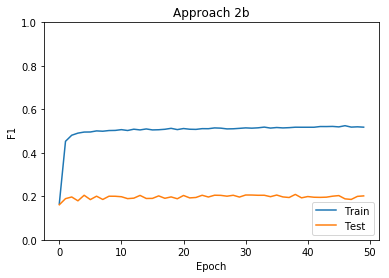

In [79]:
# Plot training & validation accuracy values
plt.plot(history_3.history['f1'])
plt.plot(history_3.history['val_f1'])
plt.title('Approach 2b')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim([0,1])
plt.show()

In [125]:
from sklearn.metrics import recall_score, precision_score
y_true = y_test.values
y_pred = np.round(model_2b.predict(X_test_user_logs)).flatten()
print("Model 2b Recall " + str(recall_score(y_true,y_pred)))
print("Model 2b Precision " + str(precision_score(y_true,y_pred)))

Model 2b Recall 0.2706766917293233
Model 2b Precision 0.17546709991876522


# User Logs, Transactions, Member Data

In [32]:
batch_size = 64
epochs = 20
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
#a = LSTM(lstm_units)(a)
a = Dense(16, activation='relu')(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([a_mod.output, b_mod.output, c_mod.output])
out = Dense(16, activation='relu')(combined)
#TODO add dropout layer
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[a_mod.input, b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

#model.summary()
model.fit([X_user_logs, X_members, X_transactions], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Epoch 1/20
24798/24798 [==============================] - 82s 3ms/step - loss: 0.4716 - auc_7: 0.8200
Epoch 2/20
24798/24798 [==============================] - 72s 3ms/step - loss: 0.4145 - auc_7: 0.8664
Epoch 3/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.4077 - auc_7: 0.8756
Epoch 4/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.4037 - auc_7: 0.8802
Epoch 5/20
24798/24798 [==============================] - 81s 3ms/step - loss: 0.4006 - auc_7: 0.8833
Epoch 6/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.3983 - auc_7: 0.8856
Epoch 7/20
24798/24798 [==============================] - 80s 3ms/step - loss: 0.3966 - auc_7: 0.8873
Epoch 8/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.3961 - auc_7: 0.8887
Epoch 9/20
24798/24798 [==============================] - 80s 3ms/step - loss: 0.3954 - auc_7: 0.8897
Epoch 10/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.

# Transactions and Member Data

In [33]:
batch_size = 64
epochs = 20
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([b_mod.output, c_mod.output])
out = Dense(16, activation='relu')(combined)
#TODO add dropout layer
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

#model.summary()
model.fit([X_members, X_transactions], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Epoch 1/20
24798/24798 [==============================] - 3s 104us/step - loss: 0.4765 - auc_8: 0.8282
Epoch 2/20
24798/24798 [==============================] - 2s 78us/step - loss: 0.4266 - auc_8: 0.8589
Epoch 3/20
24798/24798 [==============================] - 2s 81us/step - loss: 0.4209 - auc_8: 0.8659
Epoch 4/20
24798/24798 [==============================] - 2s 83us/step - loss: 0.4173 - auc_8: 0.8700
Epoch 5/20
24798/24798 [==============================] - 2s 81us/step - loss: 0.4152 - auc_8: 0.8729
Epoch 6/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4143 - auc_8: 0.8750
Epoch 7/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4128 - auc_8: 0.8766
Epoch 8/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4112 - auc_8: 0.8778
Epoch 9/20
24798/24798 [==============================] - 2s 79us/step - loss: 0.4094 - auc_8: 0.8788
Epoch 10/20
24798/24798 [==============================] - 2s 82us/step - loss: 0

# User Logs and Member Data (LSTM)

# Member data only

# Visualize Model

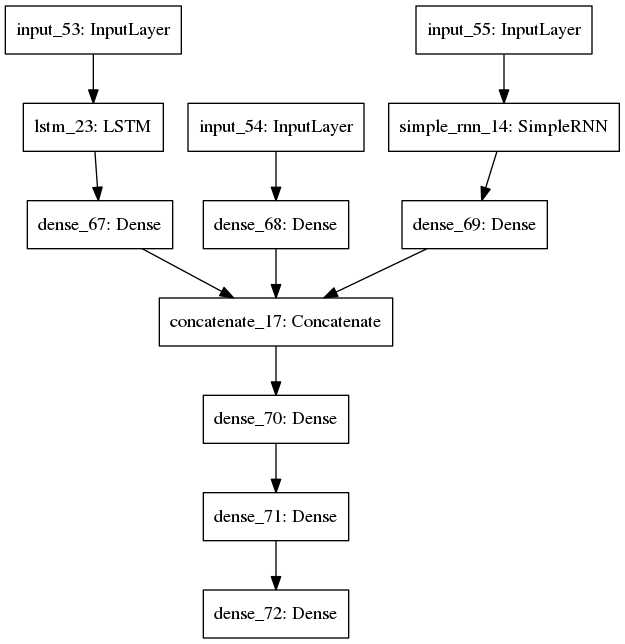

In [59]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils import plot_model
plot_model(model, to_file='model.png')